In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from myusefultools.pyopenfoam import OpenFOAM
from pathlib import Path
import multiprocessing as mp
import os
import itertools

# command = """ foamDictionary $(foamListTimes -latestTime)/h -entry boundaryField.top -set "{type uniformInletOutlet; value $internalField; uniformInletValue {type csvFile; nHeaderLine 1; refColumn 0; componentColumns (1); separator \",\"; mergeSeparators no; file \"../experimental-data/headFixed_SW150/headFixed_1.csv\";} }" """

In [8]:
## Check CASES folder exists
cases_folder = Path("CASES")
if not cases_folder.exists():
    os.mkdir(cases_folder)

template_folder = Path("template")

In [9]:
identifier = f"CASES/casetest"
of = OpenFOAM(
    path_case=identifier, write_to_log = True, path_template=template_folder
)


In [10]:
from dataclasses import dataclass

@dataclass(slots=True)
class unsatTime:
    initialTime: float
    finalTime: float
    initialHead: float
    finalHead: float

cycles = [
    unsatTime(41, 88, 0, 0.26),
    unsatTime(251, 287, 0, 0.26),
    unsatTime(461, 499, 0, 0.26),
    unsatTime(671, 708, 0, 0.26),
    unsatTime(880, 917, 0, 0.26),
    unsatTime(1089, 1125, 0, 0.26),
    unsatTime(1299, 1340, 0, 0.26),
    unsatTime(1509, 1546, 0, 0.26),
    unsatTime(1720, 1752, 0, 0.26),
]


In [11]:
# def set_boundary_csvFixedValue(self, csvfile):
#     with open(csvfile) as f:
#         _ = f.readline()
#         first_value = f.readline().split(",")[1]

#     ## Set fixedValue but reading from a CSV file
#     self.set_value_in_foamDictionary(
#         f"{self.latest_time}/h", 
#         entry="boundaryField.top",
#         value="""{type unsatTime; value """ + first_value + """; uniformValue csvFile; uniformValueCoeffs{nHeaderLine 1; refColumn 0; componentColumns (1); separator \",\"; mergeSeparators no; file \"../../""" + csvfile + """\";} }""")
#         # value="""{type uniformFixedValue; value <internalField>; uniformValue tableFile; uniformValueCoeffs{file \"""" + csvfile + """\";} }""")

    # with open(self.path_case/Path(self.latest_time, "h")) as f:
    #     input = f.read()
    #     edited = input.replace("<internalField>", "$internalField")

    # with open(self.path_case/Path(self.latest_time, "h"), "w") as f:  
    #     f.write(edited)

def set_boundary_unsatTime(self, cycle:unsatTime):
    t0 = cycle.initialTime * 60
    tf = cycle.finalTime * 60
    h0 = cycle.initialHead
    hf = cycle.finalHead

    ## Set fixedValue but reading from a CSV file
    self.set_value_in_foamDictionary(
        f"{self.latest_time}/h", 
        entry="boundaryField.top",
        value=f"""{{type unsatTime; value {h0}; initialTime {t0}; finalTime {tf}; initialHead {h0}; finalHead {hf}; }}""")
        
## Make that function a bounded method of the OpenFOAM class
setattr(OpenFOAM, set_boundary_unsatTime.__name__, set_boundary_unsatTime)

In [12]:
of.set_boundary_unsatTime(cycles[1])

In [13]:
cycle_times = [
    (41, 102),   #(time_to_dry, time_to_flood)
    (251, 311), 
    (461, 521), 
    (671, 732), 
    (880, 940), 
    (1089, 1179),
    (1299, 1359),
    (1509, 1569), 
    (1720, 1781),
    (2015, None)
]

for i, (bc, cycle) in enumerate(zip(cycles, cycle_times), start=1):
    ## Cycle 1
    ## Dry: set fixedGradient 
    
    dryt, floodt = cycle

    of.logger(f"\n🔥 ======= Cycle {i}")
    of.logger("\n🔥 ======= Dry period ======")
    if not dryt: break
    of.set_endtime(dryt)
    of.set_boundary_fixedGradient()
    of.set_convergeThreshold(0.250)
    of.cleanup_last_timestep()
    status = of.run_solver()
    of.logger(f"\nSolver ended with return code {status}")
    if status != 0: 
        print(f"Died while drying in cycle {i}", status, of.latest_time)
        break
    
    # if input("Continue?") == "NO":
    #     break

    # Flood: use meadured head
    of.logger("\n🌊 ====== Flood period ======")
    if not floodt: break

    of.set_endtime(floodt)
    of.set_boundary_unsatTime(bc)
    # headFixed_time = f"experimental-data/headFixed_SW150/headFixed_{i}.csv"
    # headFixed_time = "experimental-data/headFixed_SW150/dummy.csv"
    # of.set_boundary_csvFixedValue(headFixed_time)
    of.set_convergeThreshold(0.001)
    status = of.run_solver()
    of.logger(f"\nSolver ended with return code {status}")
    if status != 0: break

    if status != 0: 
        print(f"Died while flooding in cycle {i}", status, of.latest_time)
        break


In [14]:
print(of.latest_time, float(of.latest_time)/60, i)

106860.000 1781.0 9


In [15]:
of.foam_to_vtk()
of.boundaryProbes_to_txt()
of.process_boundaryProbes()

In [16]:
of.boundaryProbes[0].probes_points

[probePoint(x=0.1, y=0.1, z=6.0), probePoint(x=0.1, y=0.1, z=0.0)]

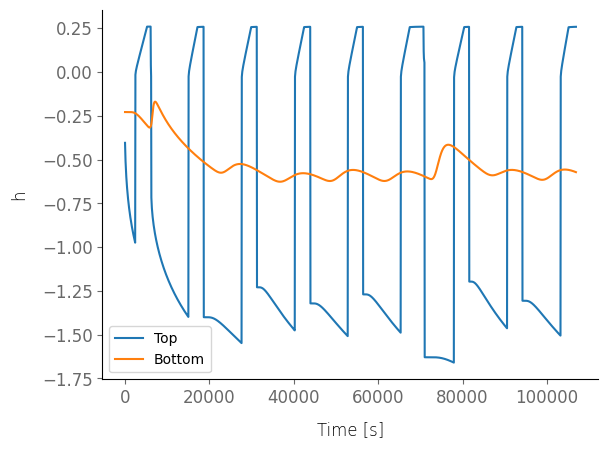

In [17]:
DIM = 0 # 0 for scalar, 1 for vector
FIELD = "h"

fig, ax = plt.subplots()
ax.plot(of.boundaryProbes[DIM].array_data.time, of.boundaryProbes[DIM].array_data[FIELD][0], label="Top")
ax.plot(of.boundaryProbes[DIM].array_data.time, of.boundaryProbes[DIM].array_data[FIELD][1], label="Bottom")
ax.legend()
ax.set_xlabel("Time [s]")
ax.set_ylabel(FIELD)
plt.show()

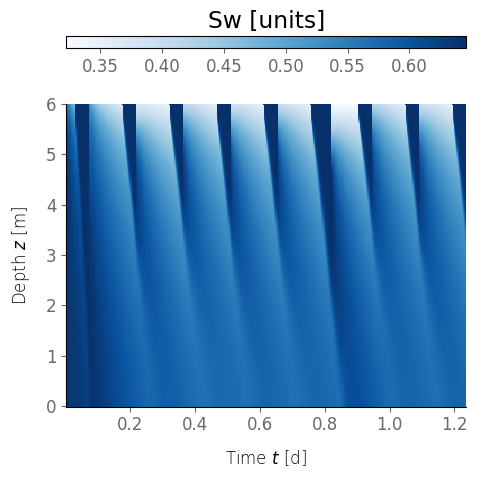

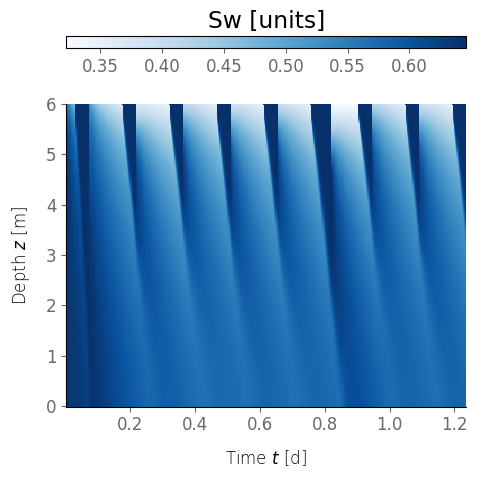

In [18]:
import json

field = "Sw"

with open("../Rosenzweig_2011/fit_ravid/heatmaps_config.json") as f:
    heatmaps_config = json.load(f)

default_pcolormesh_kwargs = dict(cmap="winter")
pcolormesh_kwargs = heatmaps_config.get(field) or default_pcolormesh_kwargs

of.plot_field_over_time(field, pcolormesh_kwargs)